In [3]:
## load packages
import os 
import pathlib
import pickle as pkl
import gdown

import sklearn
import seaborn as sns
import pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_columns', None)

#### BILLS
RULES: 
- Include states with only lobbying records (IA, MA, NE, NJ, RI, WI)
- Include only bills from years where position data is available (IA: 2009-2022, MA: 2010-2021, NE: 2000-2021, NJ: 2014-2022, RI: 2018-2022, WI: 2002-2022)
- Include bills with status avaiable and remove duplicate bills
- Subset and use columns: state, state_unified_bill_id, bill_year, pass, ncsl_topics, ncsl_metatopics

In [1]:
states_lobby = ["IA", "MA", "NE", "NJ", "RI", "WI"] #states that only have lobby records
#position data for the above states are avaible during the following ranges: 
pos_spans = [range(2009, 2023), range(2009, 2023), range(2000, 2023), range(2014, 2023), range(2018, 2023), range(2002, 2023)]

In [4]:
#BILLS
bills = pd.read_parquet("../data/raw/chorus/bills.parquet") #load bills data
bills_lob = bills[bills["state"].isin(states_lobby)]        #subset states with lobby records
bills_lob = bills_lob[bills_lob["status"].notna()]          #remove rows with no status metadata
print(f"number of duplicated bills: {len(bills_lob[bills_lob["state_unified_bill_id"].duplicated()])}")
bills_lob.drop_duplicates(subset="state_unified_bill_id",   #remove rows with duplicate bill ids
                          ignore_index=True, inplace=True)
bills_lob["pass"] = bills_lob.index.map(bills_lob["status"].isin([4,5]).to_dict())#create new col with binary pass/fail status
bills_lob = bills_lob.replace(to_replace={"ncsl_metatopics":{None: list(["M"])},  #replace none with 'M' (so it can be made to list)
                                          "ncsl_topics":{None: list(["M"])}})
bills_lob["ncsl_topics"] = bills_lob["ncsl_topics"].str.split("; ")               #split topics into lists 
bills_lob["ncsl_metatopics"] = bills_lob["ncsl_metatopics"].str.split("; ")       #split topics into lists 
print(f"number of bills after removing duplicates: {len(bills_lob)}")
#get year from last_action_date
bills_lob["year"] = bills_lob["last_action_date"].str.split(r"-", expand=True)[0]
#subset bills
bills_lob = bills_lob[["state_unified_bill_id", "pass",  "state", "ncsl_topics", "ncsl_metatopics", "year", "bill_chamber"]]
#fix year col: inspect years: none, 0000, 1969
print(f"number of bills where year is None, 0000 or 1969: {len(bills_lob[bills_lob["year"].isin([None, "0000", "1969"])])}")
#set year to year-suffix from bill id in the 374 cases above
bills_lob.loc[bills_lob[bills_lob["year"].isin([None, "0000", "1969"])].index, "year"] = bills_lob[bills_lob["year"].isin([None, "0000", "1969"])]["state_unified_bill_id"].str.split("_", expand=True)[3]
#set as type int 
bills_lob["year"] = bills_lob["year"].astype("int32")
#subset so bills only come fra year ranges where there are poistions from each state
keep_ind = []
for i, (state, span) in enumerate(zip(states_lobby, pos_spans)):
    i_ind = bills_lob[(bills_lob["state"] == state) & (bills_lob["year"].isin(span))].index.tolist()
    keep_ind = keep_ind + i_ind

bills_lob = bills_lob.iloc[keep_ind]
print(f"number of bills after removing ones outside position ranges: {len(bills_lob)}")
print(f"\nPercentage of bills passed and failed:\n{bills_lob["pass"].value_counts(normalize = True)}")
#delete to free up space 
del keep_ind, i, i_ind, state, span
bills_lob.head(3)

number of duplicated bills: 1358
number of bills after removing duplicates: 195230
number of bills where year is None, 0000 or 1969: 374
number of bills after removing ones outside position ranges: 160753

Percentage of bills passed and failed:
pass
False    0.878976
True     0.121024
Name: proportion, dtype: float64


,state_unified_bill_id,pass,state,ncsl_topics,ncsl_metatopics,year,bill_chamber
0,IA_H_0000000001_2013,False,IA,[M],[M],2013,HF
1,IA_H_0000000002_2013,False,IA,[M],[M],2013,HF
2,IA_H_0000000011_2013,False,IA,[M],[M],2013,HF


##### PLOTS 

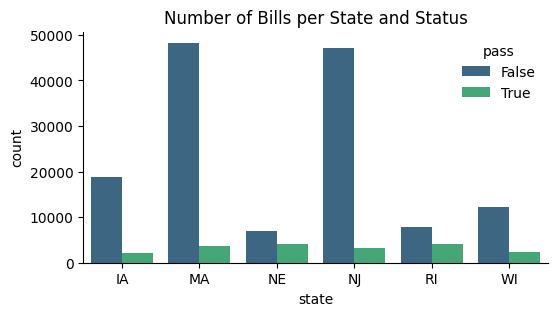

In [ ]:
#plot outcomes(passed/failed) by state
fig, ax = plt.subplots(figsize=(6, 3))
p = sns.countplot(bills_lob, x = "state", hue = "pass",stat = "count", palette= "viridis")
sns.move_legend(p, "upper right", frameon = False)
ax.set_title('Number of Bills per State and Status')
sns.despine()
plt.savefig("../figs/bills_status.png")

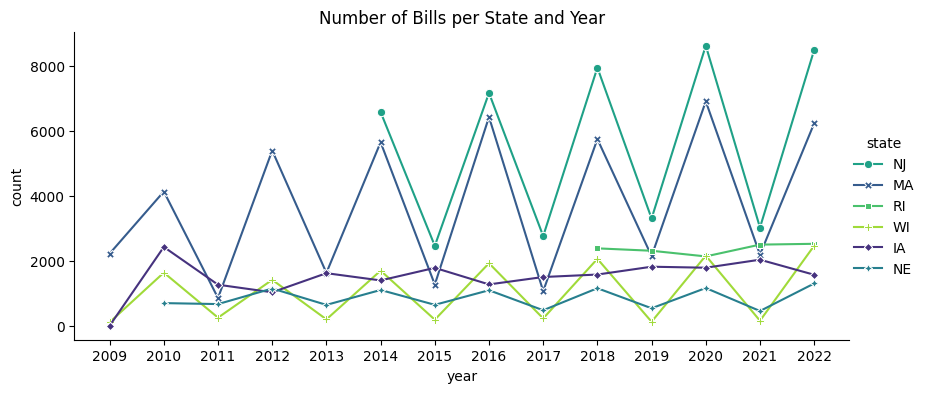

In [ ]:
##pallette so states keep the same colours through the eda
states_palette = dict(zip(states_lobby, sns.color_palette("viridis", 6).as_hex()))
#bills per state per year
fig, ax = plt.subplots(figsize=(10, 4))
p = sns.lineplot(data = bills_lob.value_counts(["state", "year"]).to_frame().reset_index(), 
                 x = "year", y = "count", hue = "state", palette= states_palette, 
                 style="state", markers=True, dashes=False)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.1, 0.7),  frameon = False)
sns.despine()
ax.set_title('Number of Bills per State and Year')
plt.xticks([2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022., ],
           ['2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020','2021','2022'])
plt.savefig("../figs/bills_lineplot.png")

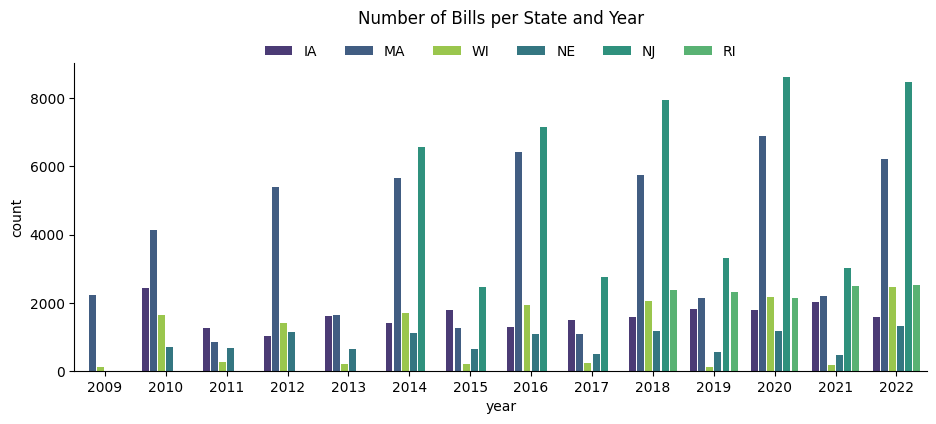

In [9]:
#bills per state per year
fig, ax = plt.subplots(figsize=(11, 4))
p = sns.countplot(bills_lob, x = "year", hue = "state",stat = "count", palette= states_palette, 
                  gap=.15)
sns.move_legend(p, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=6,  frameon=False, title=None)
ax.set_title('Number of Bills per State and Year', y = 1.1)
sns.despine()
plt.savefig("../figs/bills_barplot.png")

#### POSITIONS

RULES: 
- Include states with only lobbying records (IA, MA, NE, NJ, RI, WI)
- Include from years where bills also have been collected (IA: 2009-2022, MA: 2010-2021, NE: 2010-2021, NJ: 2014-2022, RI: 2018-2022, WI: 2009-2022)
- All bills in POSITIONS should also be in BILLS (the ones that arent represented in bills were prevously removed due to having status = NA)
- Subset relevant columns (state_client_id, state_unified_bill_id, year, position_numeric)

In [6]:
#POSITIONS
bills_spans = [range(2009, 2024), range(2009, 2023), range(2010, 2023), range(2014, 2024), range(2018, 2024), range(2009, 2024)]

positions = pd.read_parquet("../data/raw/chorus/positions.parquet")#load positions
#subset so positions only come from year ranges where there are bills from each state
keep_ind = []
for i, (state, span) in enumerate(zip(states_lobby, bills_spans)):
    i_ind = positions[(positions["state"] == state) & (positions["year"].isin(span))].index.tolist()
    keep_ind = keep_ind + i_ind
positions_lob = positions.iloc[keep_ind]
#check that bills in positions is also in bills df
print(f"number of unique bill ids in positions data: {len(positions_lob["state_unified_bill_id"].unique())}")
print(f"number of unique bill ids in bills data: {len(bills_lob["state_unified_bill_id"].unique())}")
print(f"\nOf bills in positions data also represented in bills data:")
print(positions_lob["state_unified_bill_id"].drop_duplicates().isin(bills_lob["state_unified_bill_id"]).value_counts())
### bills present in positions data but not in bills, was taken out of bills bc status value wasnt avaiable
not_in_bills = positions_lob[~positions_lob["state_unified_bill_id"].isin(bills_lob["state_unified_bill_id"])]["state_unified_bill_id"].unique()
print(bills[bills["state_unified_bill_id"].isin(not_in_bills)]["status"].isna().value_counts())
print("The bills not present in the bills dataset (3603) have status value NA (why they arent there)")
#remove the bills from positions not present in bills data
positions_lob = positions_lob[positions_lob["state_unified_bill_id"].isin(bills_lob["state_unified_bill_id"])]
#subset relevant columns 
positions_lob = positions_lob[["state_client_id", "state", "state_unified_bill_id", "position_numeric", "year"]] #keep relevant columns
positions_lob = positions_lob.replace(to_replace={"position_numeric": {-1.0: "oppose", 0.0: "neutral", 1.0: "support"}})
positions_lob.reset_index(drop=True, inplace=True)
positions_lob.head(3)
#del positions to free up space
del positions, keep_ind, i, state, span, i_ind, bills, not_in_bills

number of unique bill ids in positions data: 89350
number of unique bill ids in bills data: 160753

Of bills in positions data also represented in bills data:
state_unified_bill_id
True     85747
False     3603
Name: count, dtype: int64
status
True    3603
Name: count, dtype: int64
The bills not present in the bills dataset (3603) have status value NA (why they arent there)


##### PLOTS

In [ ]:
#bills per state per year
fig, ax = plt.subplots(figsize=(10, 4))
p = sns.lineplot(data = positions_lob.value_counts(["state", "year"]).to_frame().reset_index(), 
                 x = "year", y = "count", hue = "state", palette= states_palette, style="state",
                markers=True, dashes=False)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.1, 0.8),  frameon = False)
sns.despine()
ax.set_title('Number of Positions per State and Year')
plt.xticks([2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022., ],
           ['2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020','2021','2022'])
plt.savefig("../figs/positions_lineplot.png")

In [ ]:
#positions per state per year
fig, ax = plt.subplots(figsize=(10, 5))
p = sns.countplot(positions_lob, x = "year", hue = "state",stat = "count", palette= states_palette, 
                  gap=.15)
sns.move_legend(p, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=6,  frameon=False, title=None)
ax.set_title('Number of Positions per State and Year', y = 1.1)
sns.despine()
plt.savefig("../figs/positions_barplot.png")

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))
p = sns.countplot(positions_lob, x = "state", hue = "position_numeric",stat = "count", 
                  palette= "viridis",  gap = .1)
sns.move_legend(p, "upper center",  bbox_to_anchor=(0.5, 1.1), ncol=3,  frameon = False, title=None)
ax.set_title('Number of Positions per State and Type', y=1.1)
sns.despine()
plt.savefig("../figs/position_type.png")
del fig, ax, p

#### BLOCKS

RULES: 
- Include states with only lobbying records (IA, MA, NE, NJ, RI, WI)
- rename enity id to state client id 
- subset only rows with clients (not bills)          
- merge with positions: (orgs only in blocks are dropped )

In [ ]:
blocks = pd.read_parquet("../data/raw/chorus/block_assignments.parquet")#load positions
blocks = blocks.rename(columns={"entity_id": "state_client_id"})        #rename to state_client_id 
blocks = blocks[blocks["state"].isin(states_lobby)]                     #only states with lobby recs
blocks = blocks[blocks["state_client_id"].str.match(r"[A-Z][A-Z]_\d+")] #keep only rows with clients
print(f"Number of client ids in blocks: {len(blocks)}\nnumber of clients per {blocks["state"].value_counts()}")
blocks["block_1"] = blocks["block_1"].astype(str) #change block_1 type to str
positions_blocks = positions_lob.merge(blocks, how="left", on=["state_client_id", "state"], indicator=True)
print(f"number of client ids not in blocks: {len(positions_blocks.loc[positions_blocks["_merge"] == "left_only", "state_client_id"].unique())}")
#remove rows where no blocks have been assigned 
positions_blocks = positions_blocks[positions_blocks["_merge"] == "both"]
print(f"number of positions in total after cleaning: {len(positions_blocks)}")
blocks.head(4)

Number of client ids in blocks: 4312
number of clients per state
MA    1058
IA    1048
WI     785
NE     726
NJ     613
RI      82
Name: count, dtype: int64
number of client ids not in blocks: 7886
number of positions in total after cleaning: 1454787


,state_client_id,block_0,block_1,block_2,block_3,block_4,block_5,block_6,state,record_type
0,MA_1,3283,150,0,12,3.0,3.0,2.0,MA,lobbying
1,MA_10,4139,20,27,26,0.0,3.0,2.0,MA,lobbying
2,MA_100,3291,209,42,6,0.0,3.0,2.0,MA,lobbying
3,MA_1000,1311,128,62,26,0.0,3.0,2.0,MA,lobbying


#### MERGE DATASETS

In [8]:
pb = positions_blocks[["state_unified_bill_id", "state_client_id", "position_numeric", "block_1"]].sort_values("state_unified_bill_id").reset_index(drop=True)

In [58]:
#make array for positions and block (+counts)
block1_ls = pb["block_1"].unique()              #unique block1 values 
bill_ls = pb["state_unified_bill_id"].unique()  #unique bill ids
#emtpty array for block counts [support, neutral, oppose]
block_array = np.zeros([len(bill_ls), len(block1_ls),3], dtype = np.int32) 

In [ ]:
block_array[7896:].sum()

np.int64(0)

In [59]:
for bill in bill_ls:

    ind_bill = np.asarray(bill_ls == bill).nonzero()                    #get index of bill in list
    block_counts = pb[pb["state_unified_bill_id"]==bill].value_counts(  #get block counts 
        ["position_numeric", "block_1"])
    
    for j, (count, block) in enumerate(zip(block_counts.values, block_counts.index)):
        ind_block = np.asarray(block1_ls == block[1]).nonzero() 
        if block[0] == 'support':
            block_array[ind_bill, ind_block, 0] = count
        if block[0] == 'neutral':
            block_array[ind_bill, ind_block, 1] = count
        if block[0] == 'oppose':
            block_array[ind_bill, ind_block, 2] = count


KeyboardInterrupt: 

In [36]:
#count df: bill id, position, block, count
pb_counts = pd.DataFrame(pb.value_counts(["state_unified_bill_id", "position_numeric", "block_1"], sort = False)).reset_index()
print(pb_counts.head(1))
#pos list df: pivot df to get only one row per bill
pb_pos_list= pd.DataFrame(pb_counts.groupby(["state_unified_bill_id", "position_numeric"])["block_1"].apply(list)).reset_index().pivot(index = "state_unified_bill_id", columns= "position_numeric", values="block_1").reset_index().replace({None: list(["N"])})
#rename position headers 
pb_pos_list.rename(columns={"neutral":"neut_blocks", "oppose":"opp_blocks", "support":"sup_blocks"}, inplace=True)
print(pb_pos_list.head(1))
#count list: pivot to get counts (1 per bill)
pb_count_list= pd.DataFrame(pb_counts.groupby(["state_unified_bill_id", "position_numeric"])["count"].apply(list)).reset_index().pivot(index = "state_unified_bill_id", columns= "position_numeric", values="count").reset_index().replace({None: list([0])})
pb_count_list.rename(columns={"neutral":"neut_counts", "oppose":"opp_counts", "support":"sup_counts"}, inplace=True)
print(pb_count_list.head(1))

    state_unified_bill_id position_numeric block_1  count
0  IA_HCR_0000000003_2009          neutral     146      1
position_numeric   state_unified_bill_id neut_blocks opp_blocks sup_blocks
0                 IA_HCR_0000000003_2009       [146]          N          N
position_numeric   state_unified_bill_id neut_counts opp_counts sup_counts
0                 IA_HCR_0000000003_2009         [1]          0          0


In [37]:
##merge on bill_id
pb_list = pb_pos_list.merge(pb_count_list, on="state_unified_bill_id", how="left")

In [38]:
#MERGE BILLS AND POSITIONS DATA (PB_LIST)
features = bills_lob.merge(pb_list, on="state_unified_bill_id", how="left", indicator=True)

#delete dfs to free up space
#del bills_lob, bills_spans, blocks, pb, pb_count_list, pb_counts, pb_list, pb_pos_list, pos_spans, positions_blocks, positions_lob

In [39]:
#FIX NANS 
features["neut_blocks"] = features["neut_blocks"].replace(to_replace={None: "N"}).apply(list)
features["opp_blocks"] = features["opp_blocks"].replace(to_replace={None: "N"}).apply(list)
features["sup_blocks"] = features["sup_blocks"].replace(to_replace={None: "N"}).apply(list)
features["neut_counts"] = features["neut_counts"].replace(to_replace={None: list([0])})
features["opp_counts"] = features["opp_counts"].replace(to_replace={None: list([0])})
features["sup_counts"] = features["sup_counts"].replace(to_replace={None: list([0])})

In [40]:
features

,state_unified_bill_id,pass,state,ncsl_topics,ncsl_metatopics,year,bill_chamber,neut_blocks,opp_blocks,sup_blocks,neut_counts,opp_counts,sup_counts,_merge
0,IA_H_0000000001_2013,False,IA,[M],[M],2013,HF,"[107, 116, 196, 262, 5, 51, 70, 86]","[107, 115, 191, 62, 90]","[32, 70]","[4, 2, 12, 4, 9, 11, 1, 6]","[4, 2, 2, 4, 1]","[1, 4]",both
1,IA_H_0000000002_2013,False,IA,[M],[M],2013,HF,"[107, 119, 12, 161, 19, 196, 203, 23, 26, 262,...","[107, 115, 191, 62]","[169, 19, 262, 70]","[4, 7, 1, 6, 5, 3, 2, 2, 4, 3, 6, 11, 11, 2, 5...","[5, 1, 2, 6]","[3, 4, 4, 3]",both
2,IA_H_0000000011_2013,False,IA,[M],[M],2013,HF,"[12, 19, 220, 231, 250, 262, 45, 51, 58, 80]","[115, 181, 19, 195, 209, 212, 45]","[161, 32, 70]","[1, 14, 3, 1, 2, 3, 6, 10, 1, 2]","[1, 3, 12, 4, 3, 2, 3]","[1, 8, 1]",both
3,IA_H_0000000101_2013,False,IA,[M],[M],2013,HF,"[107, 116, 140, 195, 250, 27, 79, 90]",[N],"[140, 195, 79, 90]","[4, 1, 5, 19, 1, 1, 3, 4]",0,"[11, 1, 3, 4]",both
4,IA_H_0000002351_2013,False,IA,[M],[M],2014,HF,"[146, 19, 5]",[N],"[12, 146, 169, 23, 79, 80]","[3, 2, 3]",0,"[1, 1, 1, 1, 3, 1]",both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160748,WI_AB_0000000006_2011-X2,False,WI,[M],[M],2011,AB,[18],[N],"[131, 18, 2]",[1],0,"[1, 1, 1]",both
160749,WI_AB_0000000007_2011-X2,False,WI,[M],[M],2011,AB,[N],[N],"[121, 176]",0,0,"[1, 3]",both
160750,WI_AB_0000000008_2011-X2,False,WI,[M],[M],2011,AB,[N],[N],[N],0,0,0,left_only
160751,WI_AB_0000000009_2011-X2,False,WI,[M],[M],2011,AB,[N],[N],[176],0,0,[1],both


In [41]:
##rename some vars 
n_samples = len(features)               
print(f"number of samples: {n_samples}")
#change pass from false/true to failed/passed
features["pass"] = np.where(features['pass'] == True, 'passed', 'failed')
#change _merge values to indication of lobby or no lobby activty
features["_merge"] = np.where(features['_merge'] == "both", 'lobby', 'no_lobby')
features = features.rename(columns={"_merge": "lobbied"})
print(f"distribution of bills with position data and no position data:\n{features["lobbied"].value_counts(normalize=True)}")
features.head(5)

number of samples: 160753
distribution of bills with position data and no position data:
lobbied
lobby       0.501552
no_lobby    0.498448
Name: proportion, dtype: float64


,state_unified_bill_id,pass,state,ncsl_topics,ncsl_metatopics,year,bill_chamber,neut_blocks,opp_blocks,sup_blocks,neut_counts,opp_counts,sup_counts,lobbied
0,IA_H_0000000001_2013,failed,IA,[M],[M],2013,HF,"[107, 116, 196, 262, 5, 51, 70, 86]","[107, 115, 191, 62, 90]","[32, 70]","[4, 2, 12, 4, 9, 11, 1, 6]","[4, 2, 2, 4, 1]","[1, 4]",lobby
1,IA_H_0000000002_2013,failed,IA,[M],[M],2013,HF,"[107, 119, 12, 161, 19, 196, 203, 23, 26, 262,...","[107, 115, 191, 62]","[169, 19, 262, 70]","[4, 7, 1, 6, 5, 3, 2, 2, 4, 3, 6, 11, 11, 2, 5...","[5, 1, 2, 6]","[3, 4, 4, 3]",lobby
2,IA_H_0000000011_2013,failed,IA,[M],[M],2013,HF,"[12, 19, 220, 231, 250, 262, 45, 51, 58, 80]","[115, 181, 19, 195, 209, 212, 45]","[161, 32, 70]","[1, 14, 3, 1, 2, 3, 6, 10, 1, 2]","[1, 3, 12, 4, 3, 2, 3]","[1, 8, 1]",lobby
3,IA_H_0000000101_2013,failed,IA,[M],[M],2013,HF,"[107, 116, 140, 195, 250, 27, 79, 90]",[N],"[140, 195, 79, 90]","[4, 1, 5, 19, 1, 1, 3, 4]",0,"[11, 1, 3, 4]",lobby
4,IA_H_0000002351_2013,failed,IA,[M],[M],2014,HF,"[146, 19, 5]",[N],"[12, 146, 169, 23, 79, 80]","[3, 2, 3]",0,"[1, 1, 1, 1, 3, 1]",lobby


In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))
p = sns.countplot(features, x = "lobbied", hue = "state",stat = "count", 
                  palette= states_palette, gap = .1)
sns.move_legend(p, "upper center",  bbox_to_anchor=(0.55, 1.15), ncol=6,  frameon = False, title=None)
ax.set_title('Whether bills have been lobbyed on', y=1.15)
sns.despine()
plt.savefig("../figs/position_type.png")
del fig, ax, p

In [42]:
#fix chamber value 
features["cha"] = features["bill_chamber"].apply(lambda x: "H" if x[0] == "H" or x[0] == "A" else "S")
print("Type of 'bill_chamber' abbr. for each state:")
print(features.value_counts(["state", "cha", "bill_chamber"], sort=False))

Type of 'bill_chamber' abbr. for each state:
state  cha  bill_chamber
IA     H    HCR               128
            HF               8884
            HJR               151
            HR                445
            HSB              2237
       S    SCR                67
            SF               6422
            SJR               137
            SR                300
            SSB              2296
MA     H    H               33457
       S    S               18383
NE     S    LB               7466
            LR               3610
NJ     H    A               26617
            ACR              1110
            AJR               920
            AR               1252
       S    S               18420
            SCR               788
            SJR               569
            SR                658
RI     H    H                6773
       S    S                5070
WI     H    AB               7071
            AJR               836
            AR                187
       S    

#### LEGISLATURE COMPOSITION



In [43]:
state_ide = pd.read_csv("../data/raw/shormccarty/shor mccarty 1993-2020 state aggregate data April 2023 release.tab", sep='\t')
state_ide = state_ide[state_ide["st"].isin(states_lobby)]                       #subset states
state_ide = state_ide[state_ide["year"].isin(features["year"].unique())]   #subset years
#subset cols 
state_ide = state_ide[[
    'st', 'year', 'hou_chamber', 'sen_chamber', 'hou_dem', 'hou_rep', 'hou_majority', 'hou_minority',
    'hou_dem_mean', 'hou_rep_mean', 'sen_dem', 'sen_rep', 'sen_majority', 'sen_minority', 'sen_dem_mean', 
    'sen_rep_mean', 'h_diffs', 's_diffs', 'h_distance', 's_distance', 'h_dem_sd', 's_dem_sd', 'h_rep_sd', 
    's_rep_sd', 'h_chamber_sd', 's_chamber_sd', 'hou_dem_error', 'hou_chamber_error', 'hou_rep_error', 
    'hou_majority_error', 'sen_dem_error', 'sen_chamber_error', 'sen_rep_error', 'sen_majority_error']]
state_ide = state_ide.rename(columns={"st": "state"})

In [44]:
#split df and rbind
sta_sen = state_ide.filter(regex=r'sen|s_|year|state').reset_index(drop=True)
sta_hou = state_ide.filter(regex=r'hou|h_|year|state').reset_index(drop=True)
sta_sen.loc[0:72, "cha"] = ['S']*72  #add chamber col
sta_hou.loc[0:72, "cha"] = ['H']*72  #add chamber col
sta_sen.columns = sta_sen.columns.str.removeprefix("sen_").str.removeprefix("s_")
sta_hou.columns = sta_hou.columns.str.removeprefix("hou_").str.removeprefix("h_")
#concat!
state_ide = pd.concat([sta_sen, sta_hou]) 

In [45]:
#merge features with state_ide: remove rows where ideology data isnt avaiable (i.e. years >2020)
features_ide = features.merge(state_ide, on=["state", "year", "cha"], how="inner")

In [ ]:
#bills per state per year (after removing years where ideology data isnt avaible )
fig, ax = plt.subplots(figsize=(10, 4))
p = sns.lineplot(data = features_ide.value_counts(["state", "year"]).to_frame().reset_index(), 
                 x = "year", y = "count", hue = "state", palette= states_palette, 
                 style="state", markers=True, dashes=False)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.1, 0.7),  frameon = False)
sns.despine()
ax.set_title('Number of Bills per State and Year')
plt.xticks([2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020.],
           ['2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020',])
plt.savefig("../figs/bills_lineplot_cor.png")

In [46]:
#split y and X
y = features_ide["pass"]
X = features_ide[["state", "ncsl_metatopics", "cha", "lobbied", "neut_blocks", "opp_blocks", "sup_blocks",
              "neut_counts", "opp_counts", "sup_counts", "chamber", "dem", "rep", "majority", "minority", 
              "dem_mean", "rep_mean", "diffs", "distance"]]

In [47]:
###save selected features to parquet 
with open("../data/preprocessed/features.pkl", 'wb') as file:
    pkl.dump((X,y), file)

### FEATURE TRANSFORMATIONS

- PASS: outcome - remove from remaining data !
- STATE: one hot encoding
- TOPICS: multi-var encoding
- METATOPICS: multi-var encoding
- YEAR: ordinal encoding
- BLOCKS: multi-var encoding
- COUNTS: multi-var enc structure; but keeping values and log transforming

In [ ]:
#get saved features 
with open('../data/preprocessed/features.pkl', 'rb') as file:
    features = pkl.load(file)


In [ ]:
#STATES
enc_states = OneHotEncoder()
X_states = enc_states.fit_transform(features[["state"]].to_numpy())
names_states = enc_states.get_feature_names_out(["state"]) 
print(f"X_states have same length as n_samples: {X_states.shape[0] == n_samples}")

#LOBBIED
enc_lobbied = OneHotEncoder()
X_lobbied = enc_lobbied.fit_transform(features[["lobbied"]].to_numpy())
names_lobbied = enc_lobbied.get_feature_names_out(["lobbied"]) 
print(f"X_lobbied have same length as n_samples: {X_lobbied.shape[0] == n_samples}")

#TOPICS & METATOPICS
enc_topics = CountVectorizer(analyzer=lambda lst: lst)
X_topics = enc_topics.fit_transform(features["ncsl_topics"]).toarray()
names_topics = enc_topics.get_feature_names_out() 
print(f"X_topics have same length as n_samples: {X_topics.shape[0] == n_samples}")

enc_metatopics = CountVectorizer(analyzer=lambda lst: lst)
X_metatopics = enc_metatopics.fit_transform(features["ncsl_metatopics"]).toarray()
names_metatopics = enc_metatopics.get_feature_names_out() 
print(f"X_metatopics have same length as n_samples: {X_metatopics.shape[0] == n_samples}")

#BLOCKS: NEUTRAL, OPPOSE, SUPPORT
enc_blocks = CountVectorizer(analyzer=lambda lst: lst)
#concatenate neut_blocks, opp_blocks and sup_blocks and fit encoder to them
enc_blocks.fit(np.concatenate((features["neut_blocks"].to_numpy(), features["opp_blocks"].to_numpy(), features["sup_blocks"].to_numpy())))
blocks_names = enc_blocks.get_feature_names_out()
#transform each of the cols 
X_neut_blocks = enc_blocks.transform(features["neut_blocks"]).toarray()
X_sup_blocks = enc_blocks.transform(features["sup_blocks"]).toarray()
X_opp_blocks = enc_blocks.transform(features["opp_blocks"]).toarray()

#BLOCKS: COUNTS
#assign count values to given block indeces in each of the position cols
x_opp_counts = features["opp_counts"] #count features: oppose
x_sup_counts = features["sup_counts"] #count features: support
x_neut_counts = features["neut_counts"] #count features: neutral

X_opp_blocks = block_counts(X_opp_blocks, x_opp_counts)
X_sup_blocks = block_counts(X_sup_blocks, x_sup_counts)
X_neut_blocks = block_counts(X_neut_blocks, x_neut_counts)
print(f"X_neut_blocks have same length as n_samples: {X_neut_blocks.shape[0] == n_samples}\nX_opp_blocks have same length as n_samples: {X_opp_blocks.shape[0] == n_samples}\nX_sup_blocks have same length as n_samples: {X_sup_blocks.shape[0] == n_samples}\n")

#YEARS
years = [[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]]
enc_year = OrdinalEncoder(categories= years, dtype="int32")
X_year = enc_year.fit_transform(features[["bill_year"]].to_numpy())
names_year = enc_year.get_feature_names_out(["bill_year"])
enc_year.categories_
print(f"X_year have same length as n_samples: {X_year.shape[0] == n_samples}")